In [8]:
import os 

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
import sklearn.metrics
from matplotlib import pyplot as plt
import seaborn as sns

In [9]:
#adata=sc.read(results_file_post)
#adata.uns['log1p'] = {"base":None}

In [10]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 python-igraph==0.10.4 pynndescent==0.5.12


In [11]:
#%matplotlib inline

In [12]:
writeDir = "write/"

fileName = "mouseColon11302"

resultsFileQC = writeDir + fileName + '_QC.h5ad' 


In [13]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, fontsize=10, format='png')
sc.settings.figdir = "figures/" + fileName + "/"
figName = fileName

# Read In Data

In [14]:
inDir = f'data/{fileName}'
os.listdir(inDir)

['counts_matrix.txt',
 'E-MTAB-11284idf.txt',
 '.ipynb_checkpoints',
 'E-MTAB-11284sdrf.txt']

In [15]:
adata = sc.read_text(f'data/{fileName}/counts_matrix.txt')
adata

AnnData object with n_obs × n_vars = 3430 × 27287

In [16]:
meta = pd.read_table(f'data/{fileName}/E-MTAB-11284sdrf.txt')

# QC

normalizing counts per cell
    finished (0:00:00)


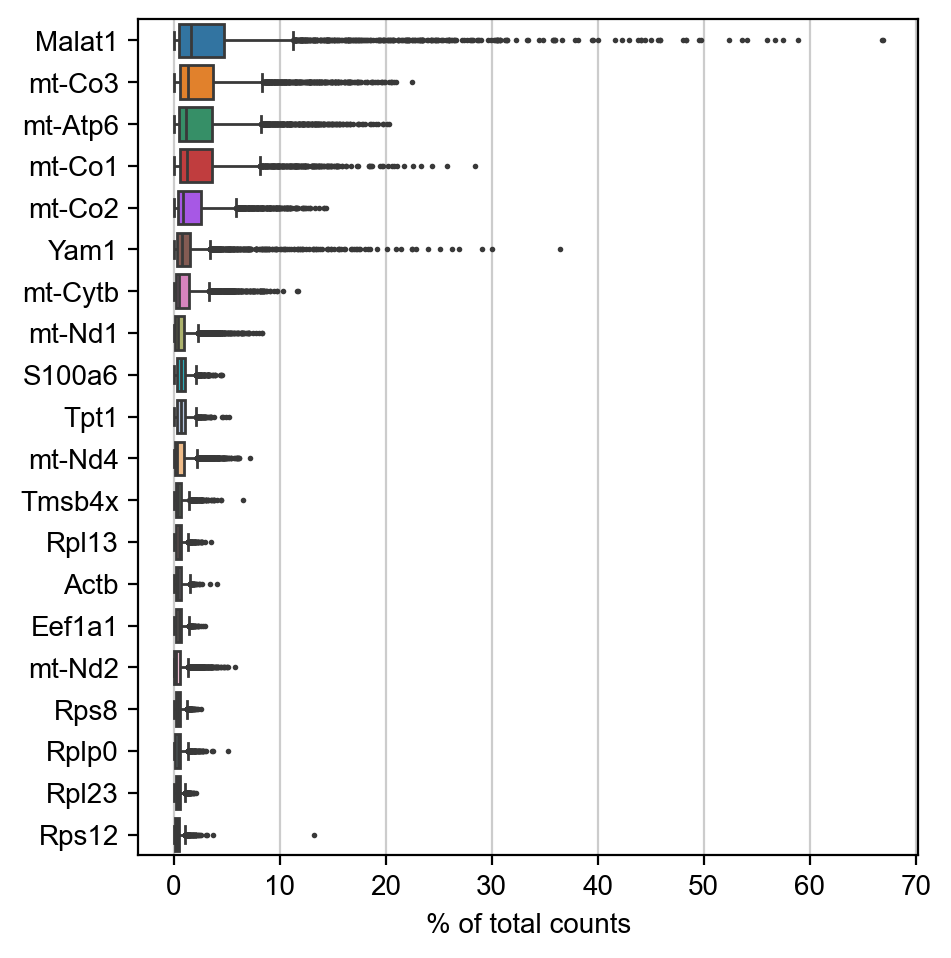

In [17]:
sc.pl.highest_expr_genes(adata, n_top=20, )

/tmp/ipykernel_1198538/1470248870.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


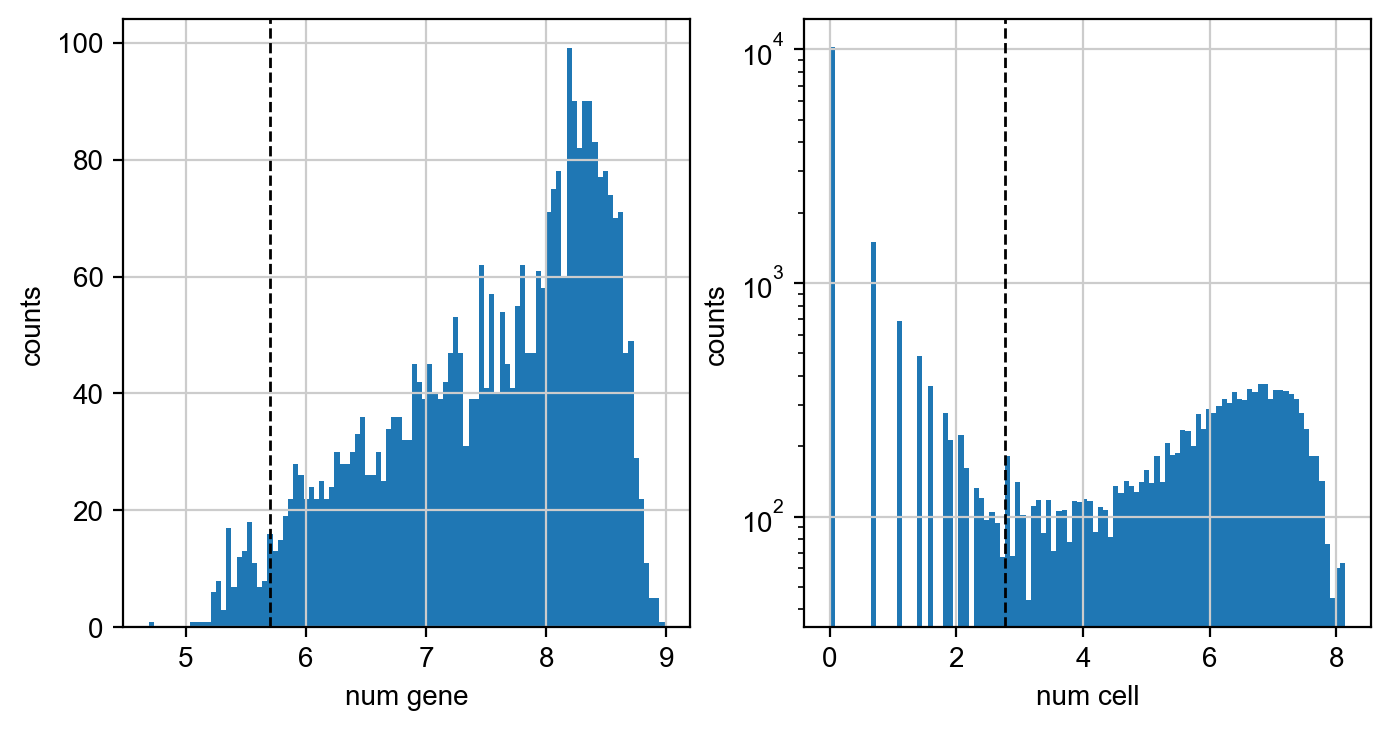

In [18]:
valX = adata.X>0
minGenes=300
minCells=15

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

numCellwExp = valX.sum(axis=1)
axs[0].hist(np.log(numCellwExp), bins=100)#, log=True)
axs[0].axvline(np.log(minGenes), color='k', linestyle='dashed', linewidth=1)
axs[0].set_xlabel('num gene')
axs[0].set_ylabel('counts')

numGeneswExp = valX.sum(axis=0).T
axs[1].hist(np.log(numGeneswExp+1), bins=100, log=True)
axs[1].axvline(np.log(minCells+1), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(600), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(4000), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].set_title('Gene means counts')
axs[1].set_xlabel('num cell')
axs[1].set_ylabel('counts')

fig.show()

In [20]:
sc.pp.filter_cells(adata, min_genes = minGenes)
sc.pp.filter_genes(adata, min_cells = minCells)

filtered out 123 cells that have less than 300 genes expressed
filtered out 14753 genes that are detected in less than 15 cells


In [21]:
adata = adata[:,np.logical_not(adata.var_names=="Malat1")]

## Mito QC

In [22]:
for g in adata.var_names:
    if "MT-" == g[:2]:
        print(g)

In [23]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], log1p = False, inplace=True)

/tmp/ipykernel_2186928/3426326396.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('mt-')


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


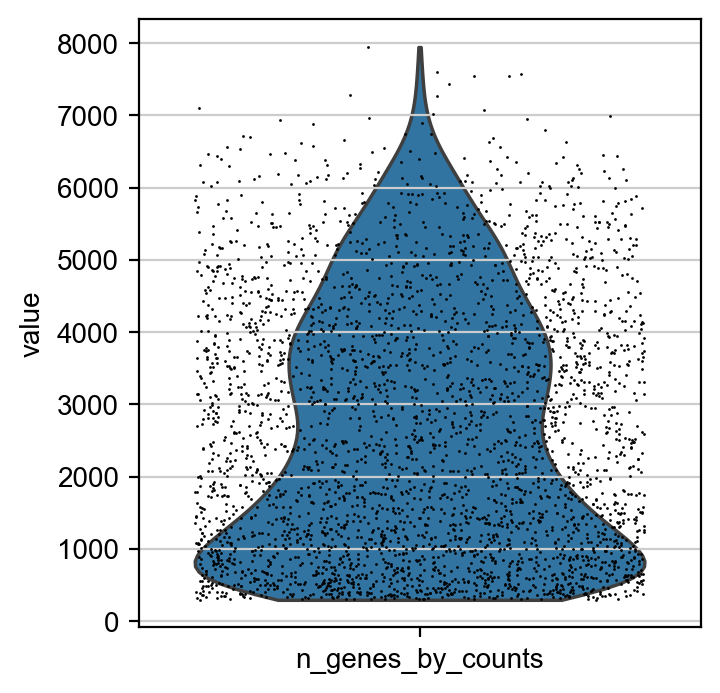

In [24]:
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4)

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


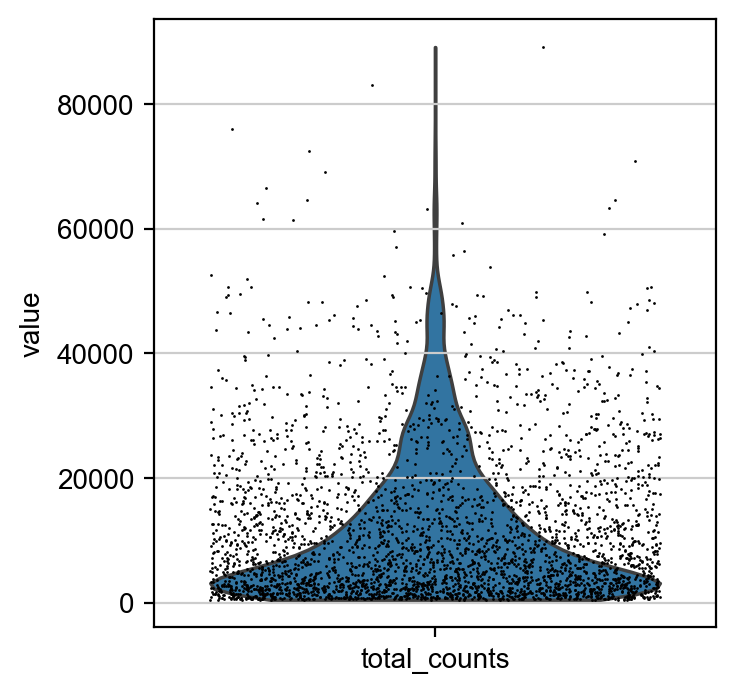

In [25]:
sc.pl.violin(adata, ['total_counts'], jitter=0.4)

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


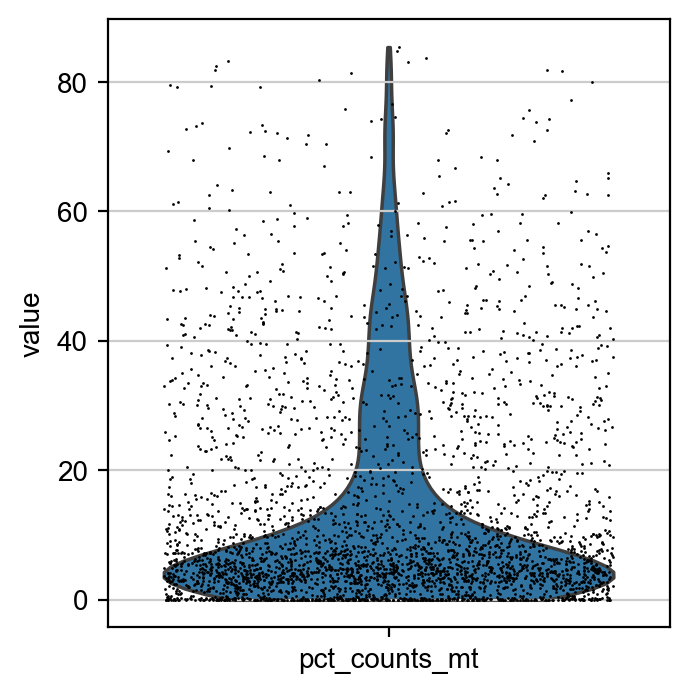

In [26]:
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4)

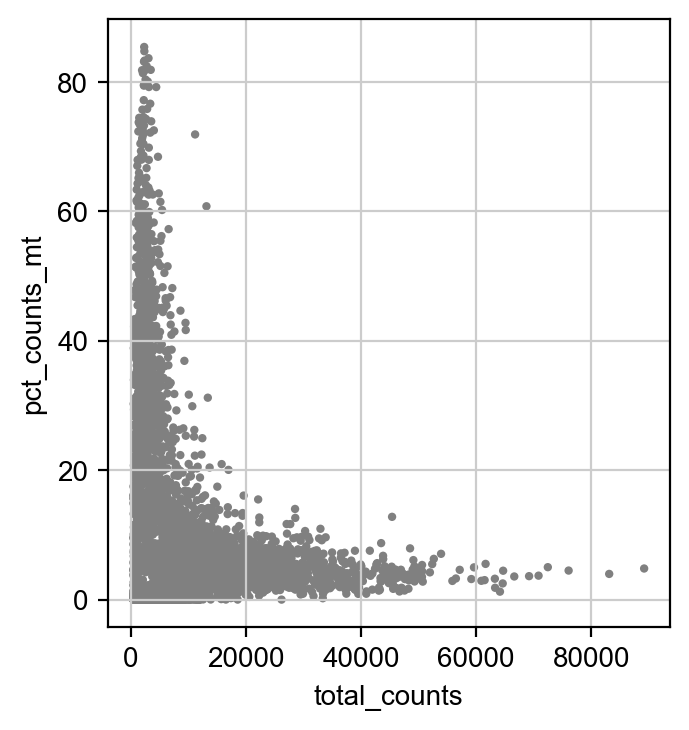

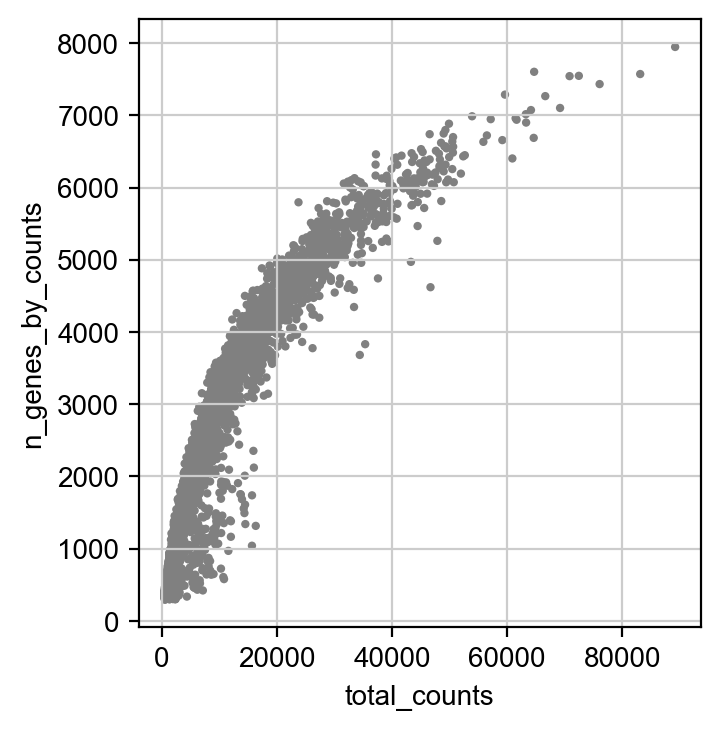

In [27]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

remove cells that have too much mito or could be doublets

In [31]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.total_counts < 40000, :]
adata = adata[adata.obs.total_counts > 100, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

save post QC scanpy

In [32]:
adata

View of AnnData object with n_obs × n_vars = 2260 × 12533
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [33]:
resultsFileQC

'write/mouseColon11302_QC.h5ad'

In [34]:
adata.write(resultsFileQC)

# Analysis

In [35]:
resultsFile = writeDir + fileName + '.h5ad'       # final output
resultsFileQC = writeDir + fileName + '_QC.h5ad'  # post QC (pre-analysis) 

In [36]:
sc.set_figure_params(scanpy=True, dpi=200, dpi_save=150, fontsize=10, format='png')
sc.settings.figdir = "figures/" + fileName + "/"
figName = fileName

In [37]:
adata = sc.read_h5ad(resultsFileQC)
adata

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 2260 × 12533
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [38]:
sc.pp.normalize_total(adata,target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [39]:
sc.pp.log1p(adata)

In [40]:
sc.pp.highly_variable_genes(adata)#, flavor = "seurat", n_top_genes=2000)

extracting highly variable genes


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


2063


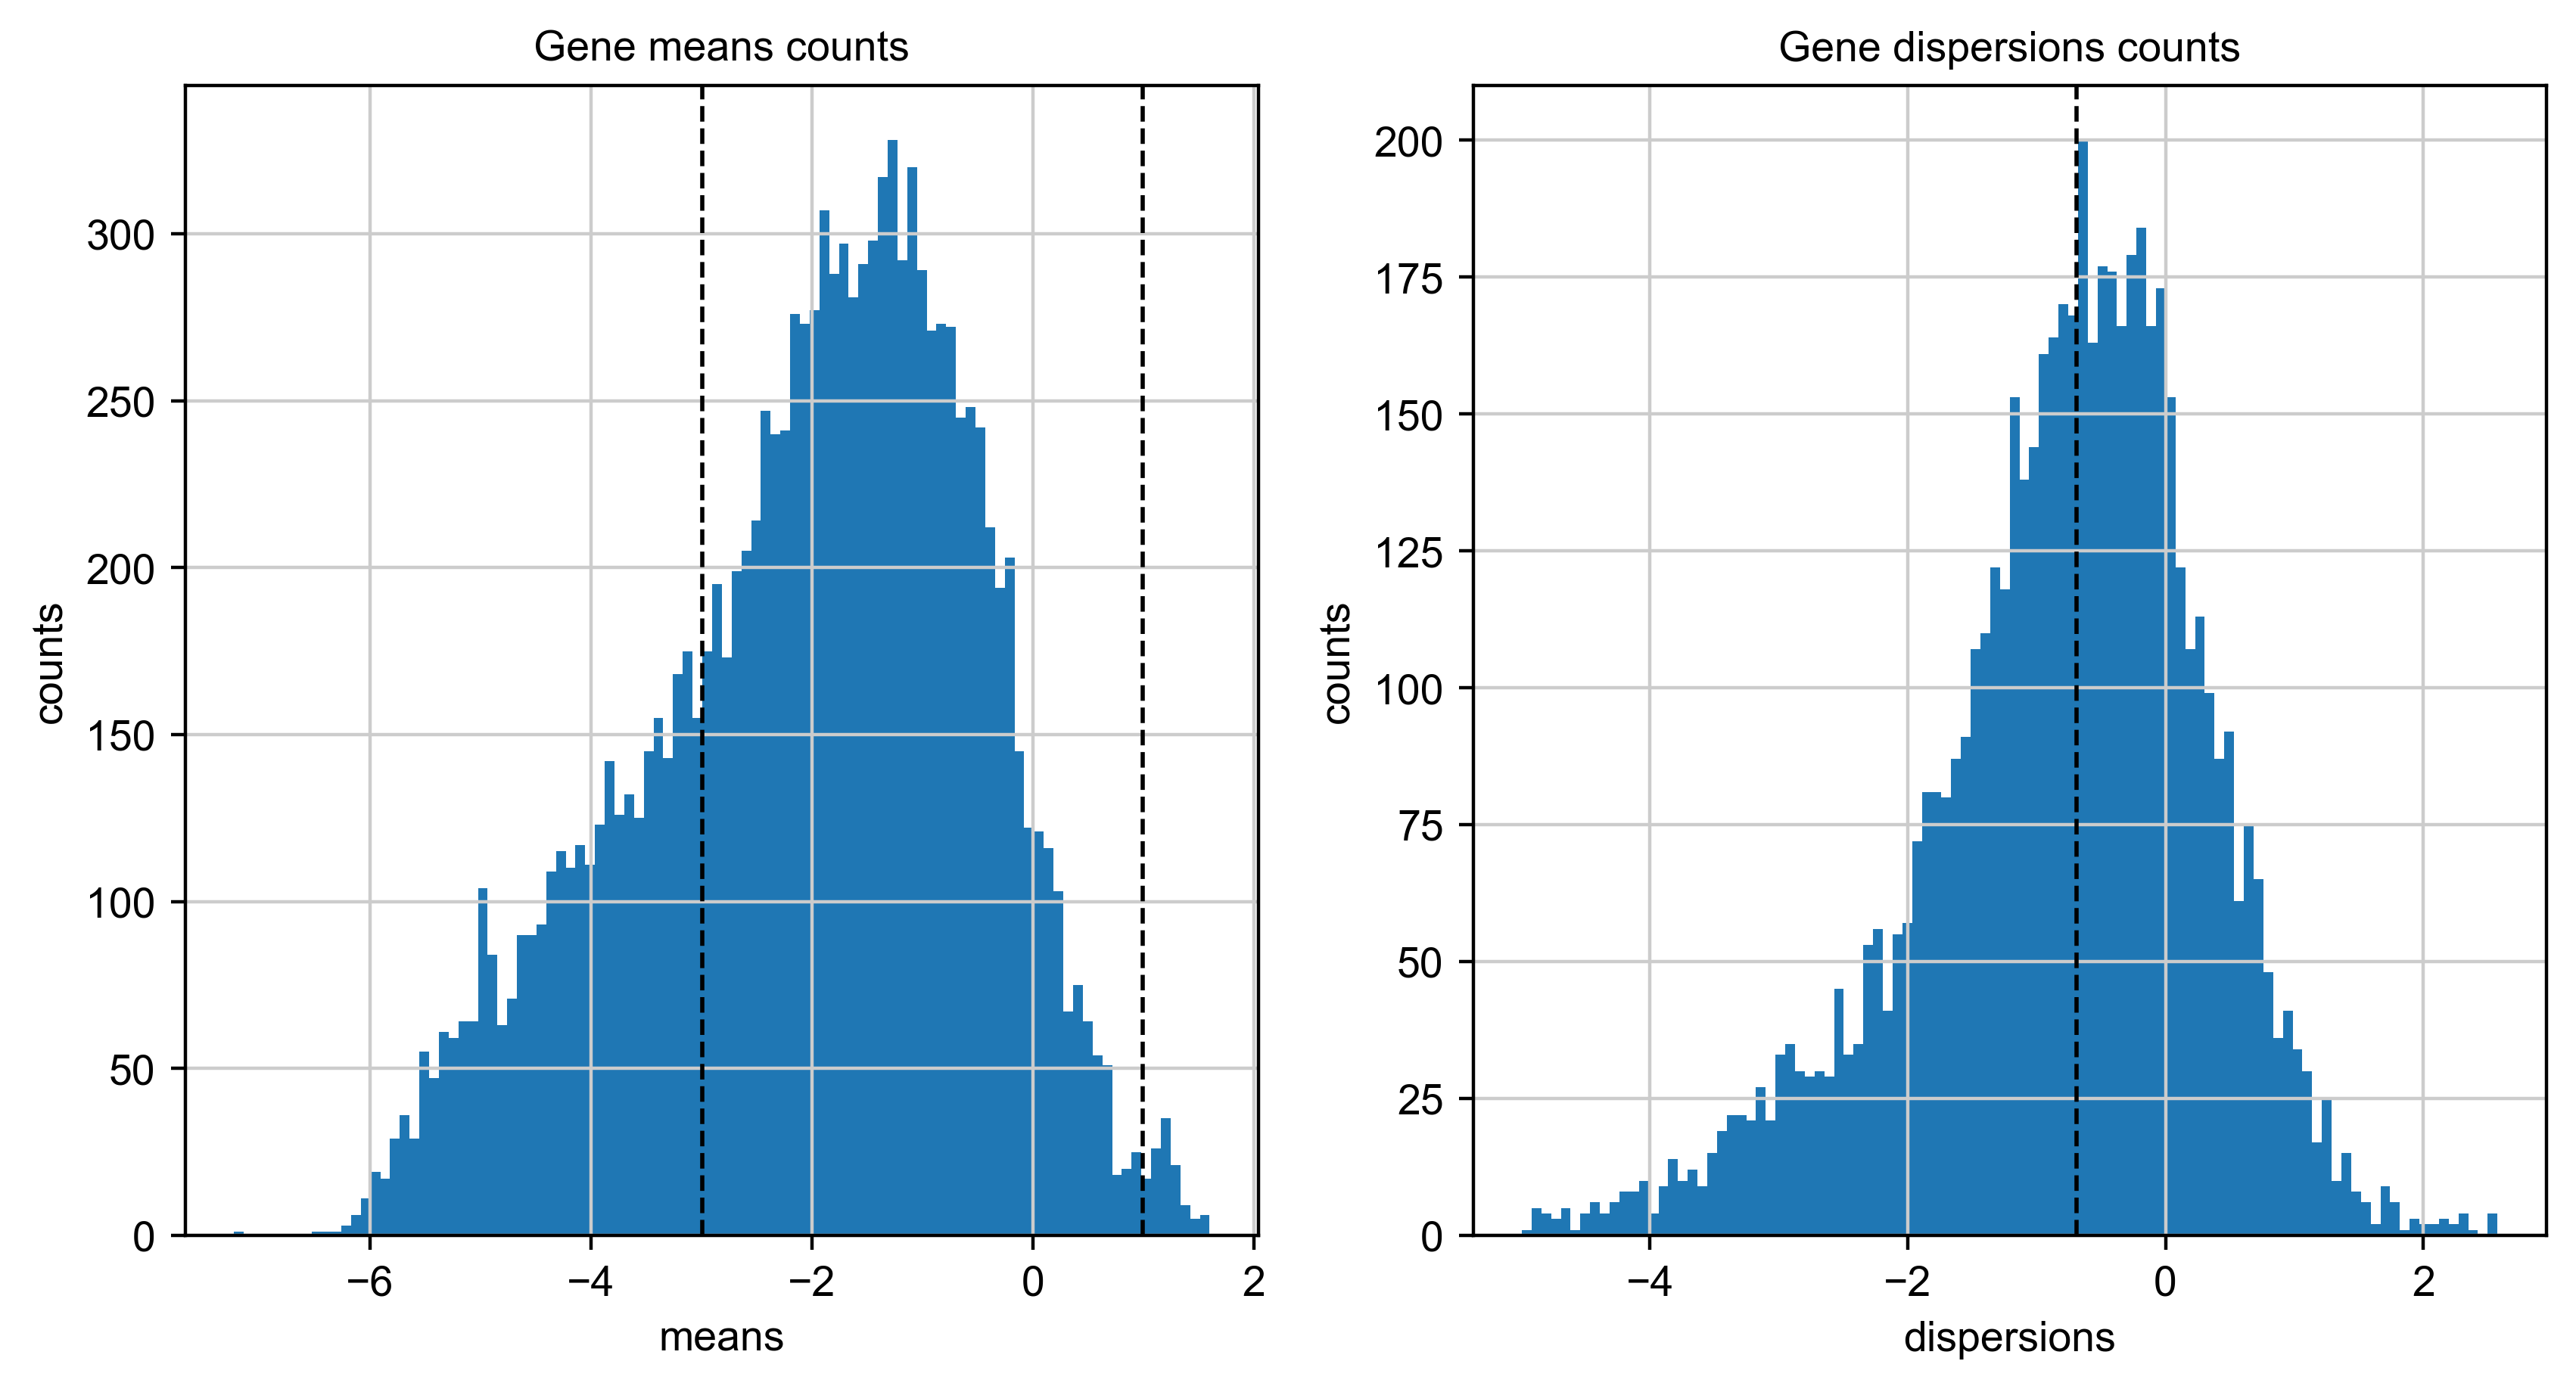

In [45]:
minMean = 0.05
maxMean = 2.7
minDisp = 0.5

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

means = adata.var[["means"]][adata.var[["means"]] > np.exp(-14)]#adata.var[["means"]],
axs[0].hist(np.log(means), bins=100)#, log=True),
axs[0].axvline(np.log(minMean), color='k', linestyle='dashed', linewidth=1)
axs[0].axvline(np.log(maxMean), color='k', linestyle='dashed', linewidth=1)
axs[0].set_title('Gene means counts')
axs[0].set_xlabel('means')
axs[0].set_ylabel('counts')

dispNorm = adata.var[["dispersions_norm"]][adata.var[["dispersions_norm"]] > np.exp(-5)]#adata.var[["means"]],
axs[1].hist(np.log(dispNorm), bins=100)#, log=True),
axs[1].axvline(np.log(minDisp), color='k', linestyle='dashed', linewidth=1)
axs[1].set_title('Gene dispersions counts')
axs[1].set_xlabel('dispersions')
axs[1].set_ylabel('counts')

sc.pp.highly_variable_genes(adata, min_disp=minDisp, min_mean=minMean, max_mean=maxMean)
print(sum(adata.var.highly_variable))

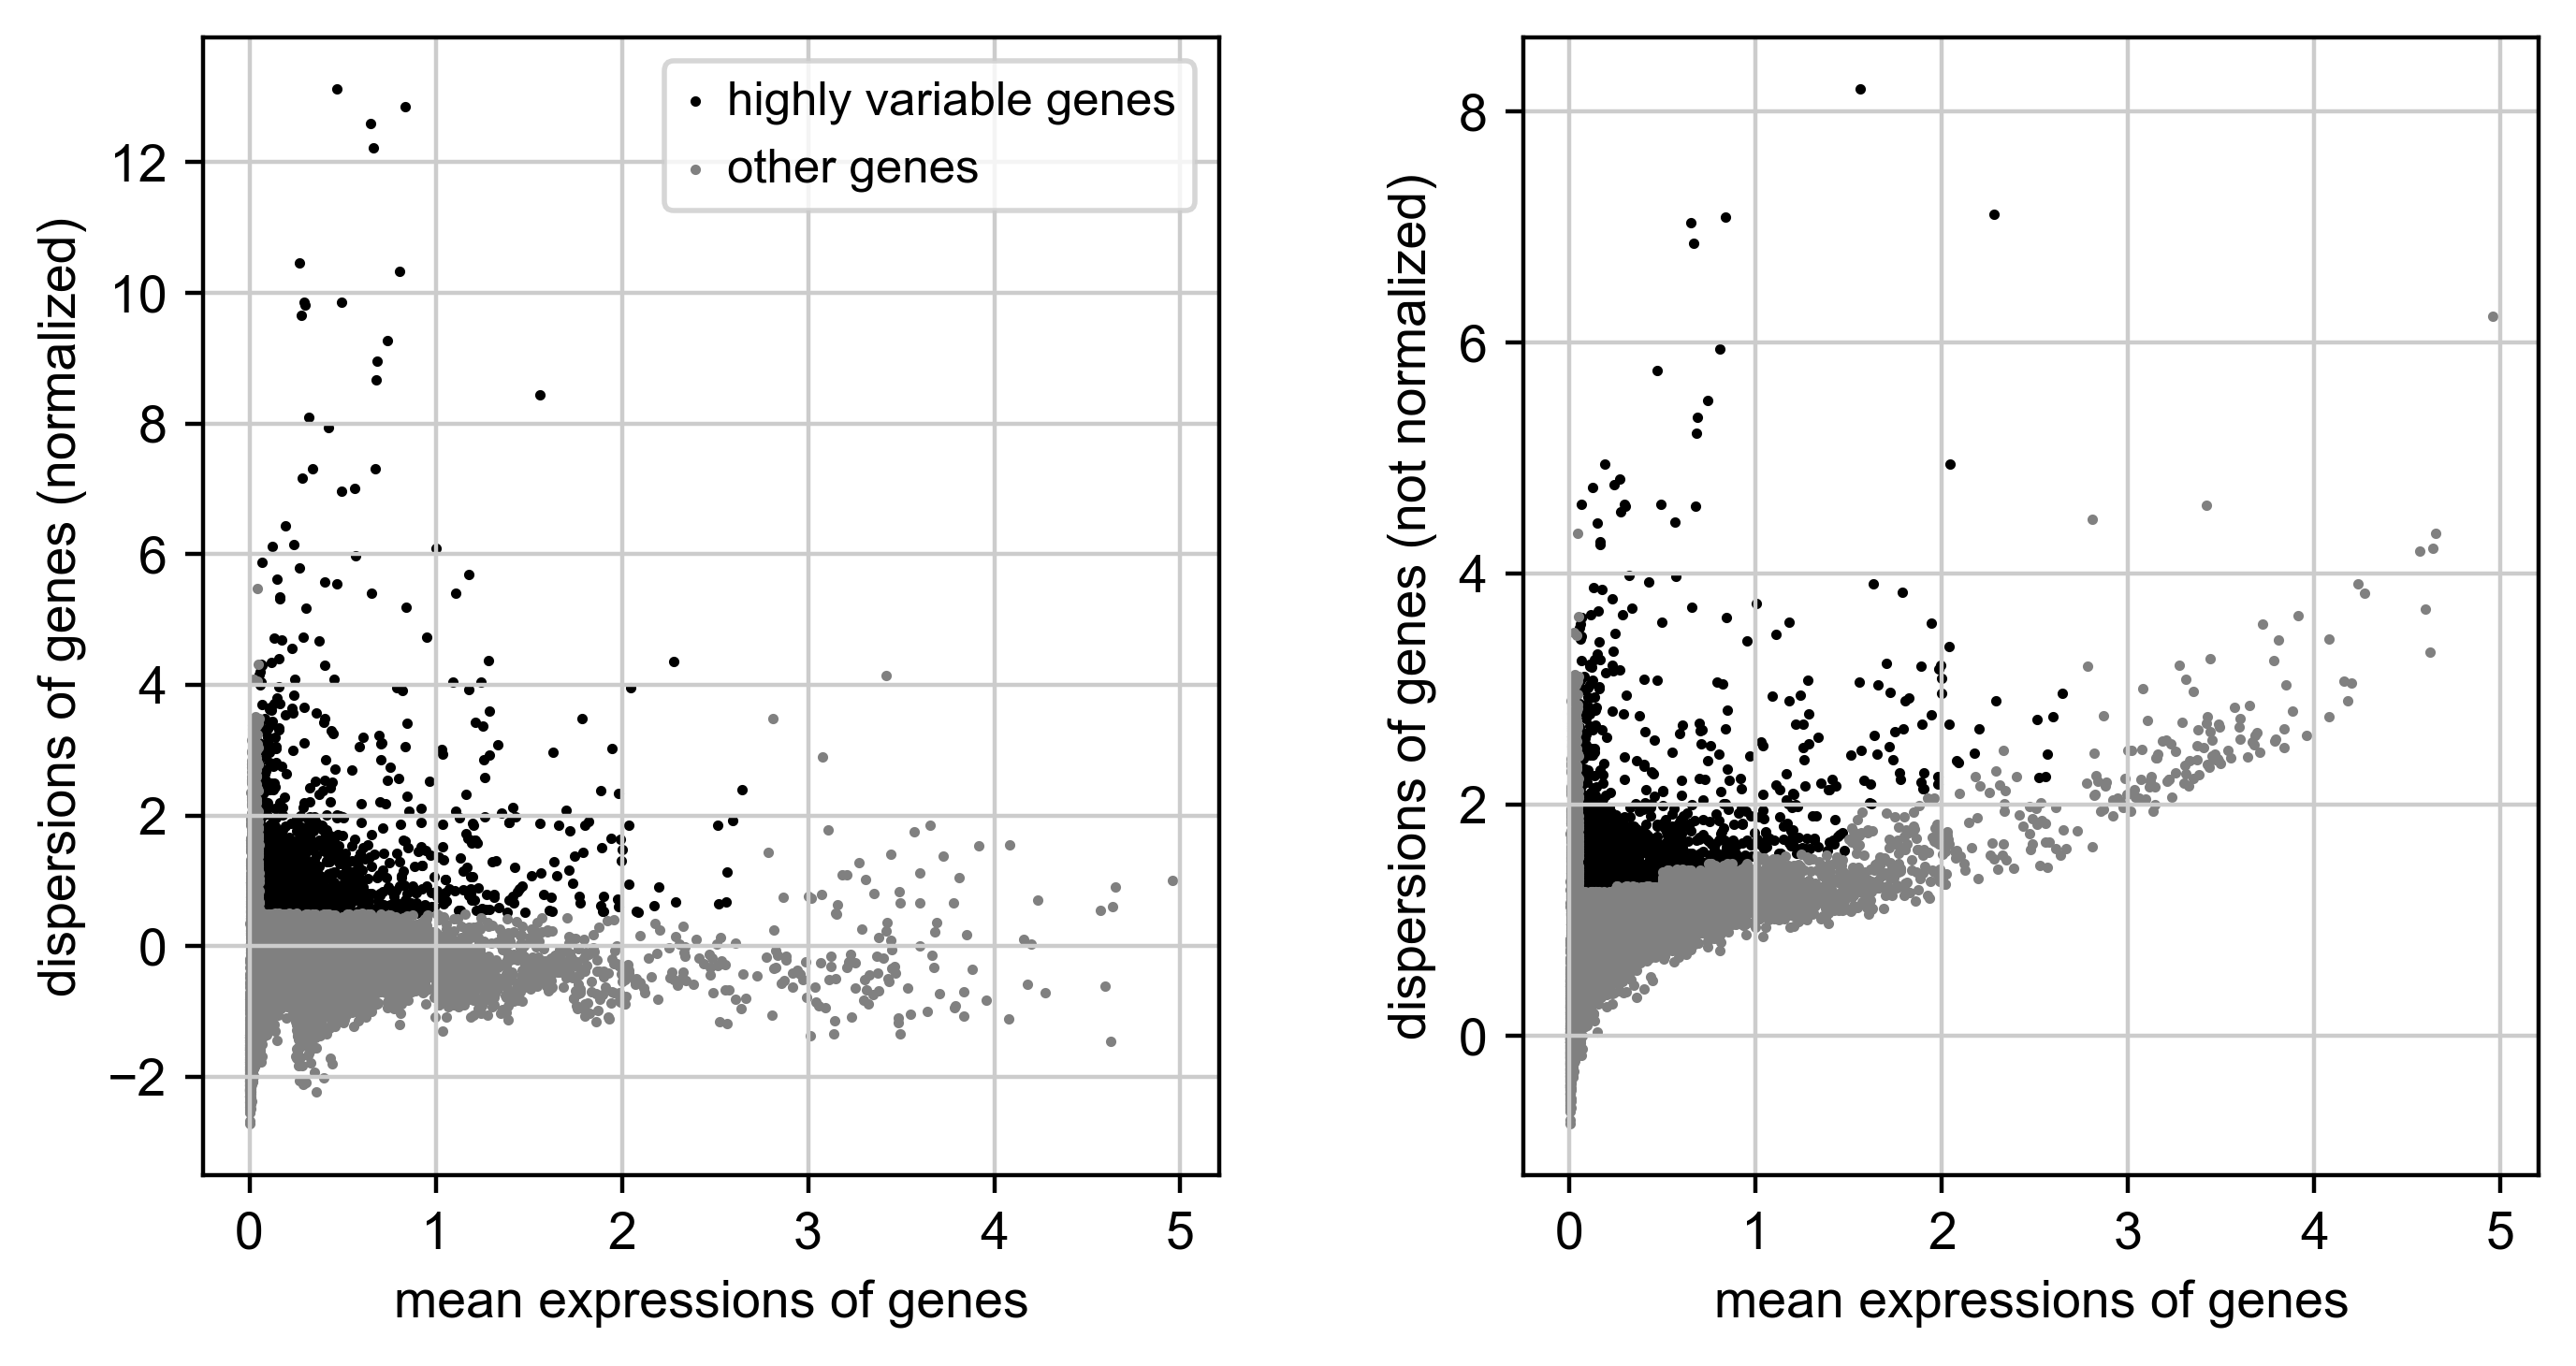

In [46]:
sc.pl.highly_variable_genes(adata)

In [47]:
#for inGene in adata.var[-8:].index.tolist():
#    adata.var.loc[inGene,"highly_variable"] = False

In [48]:
adata.raw = adata

In [49]:
#adata = adata[:, adata.var.highly_variable]
adata = adata[:, np.logical_and(adata.var.highly_variable, np.logical_not(adata.var.mt))]

In [50]:
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [51]:
#sc.pp.scale(adata, max_value=10)

In [52]:
sc.tl.pca(adata, n_comps = 100, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:00)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


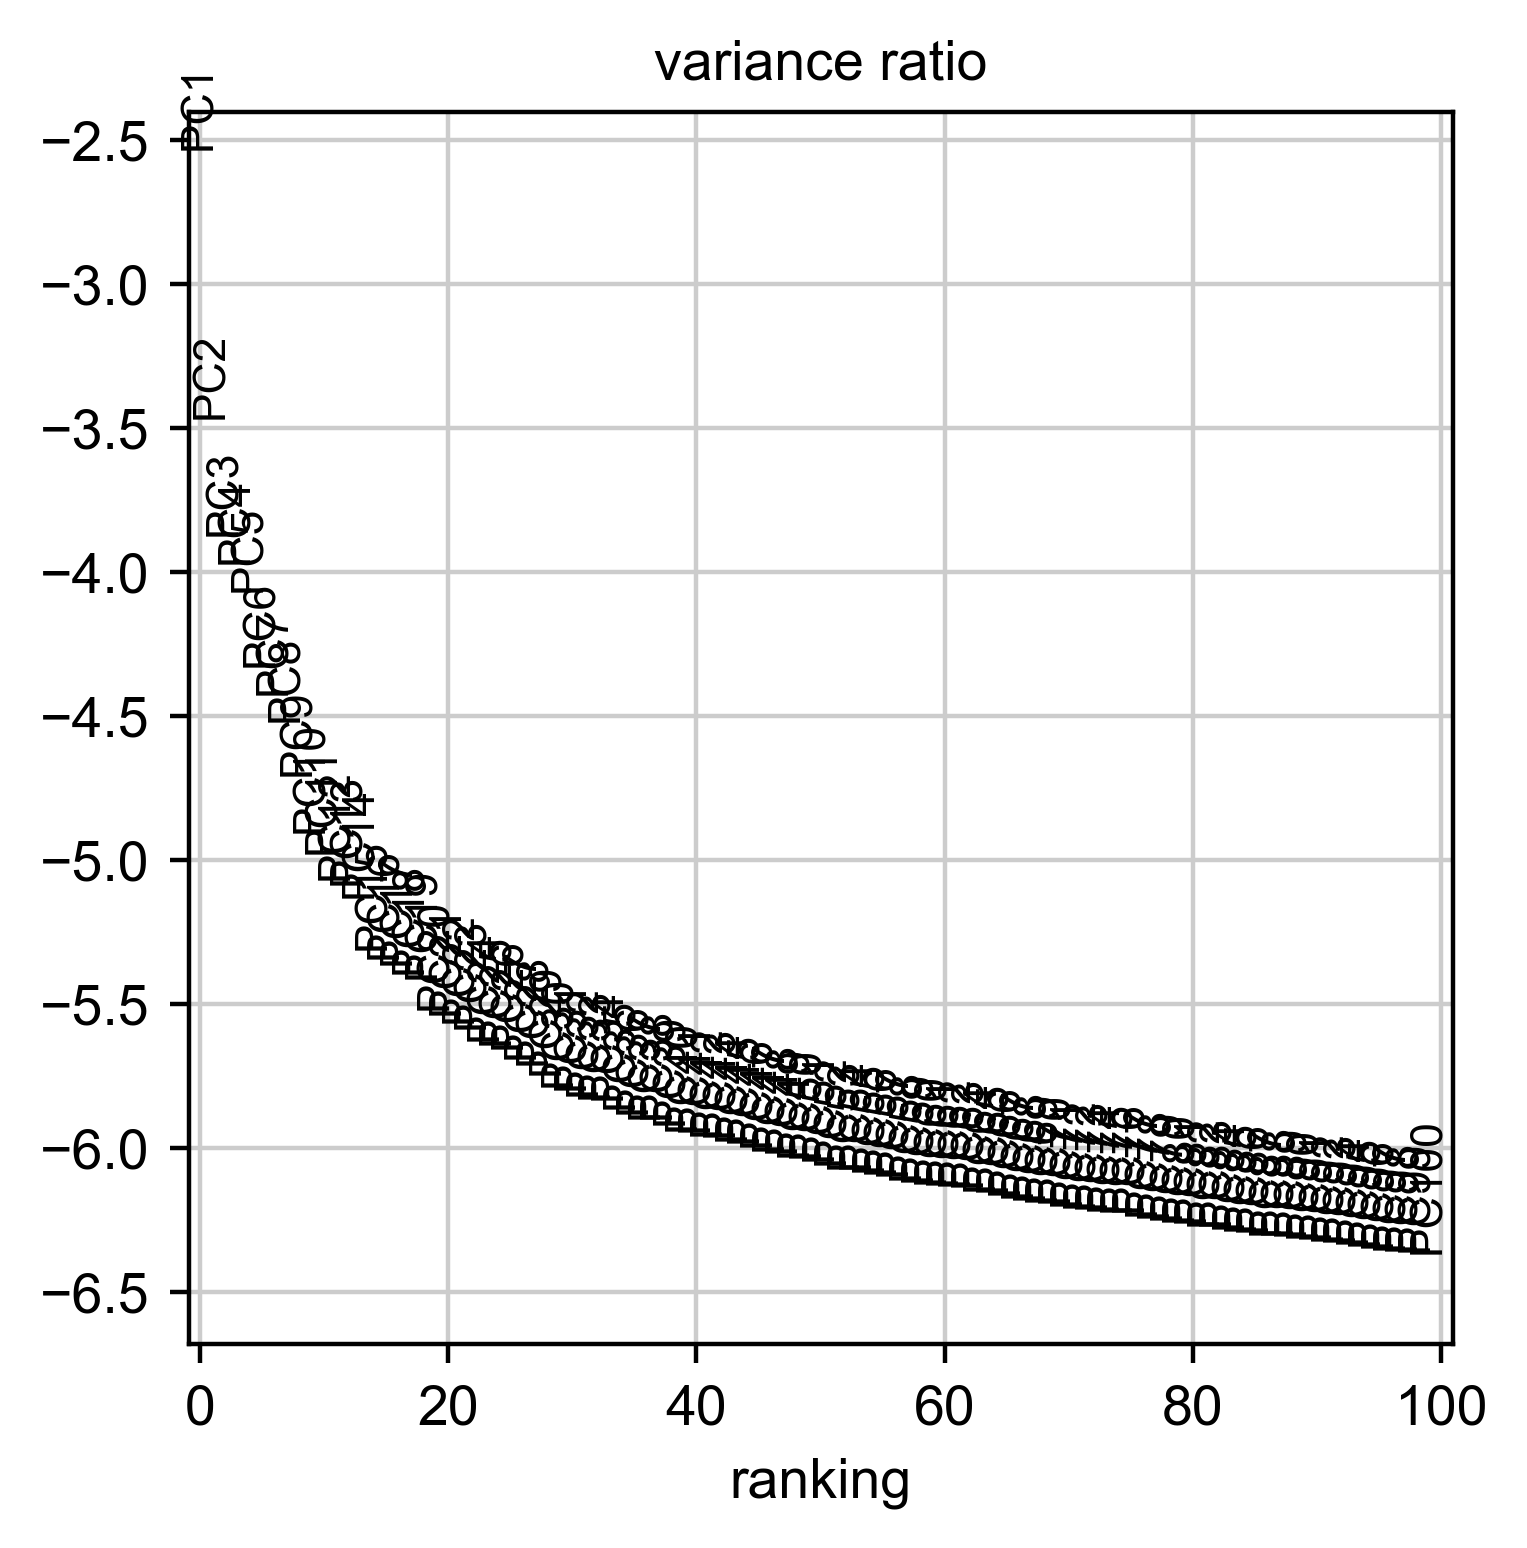

In [53]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100, log=True)

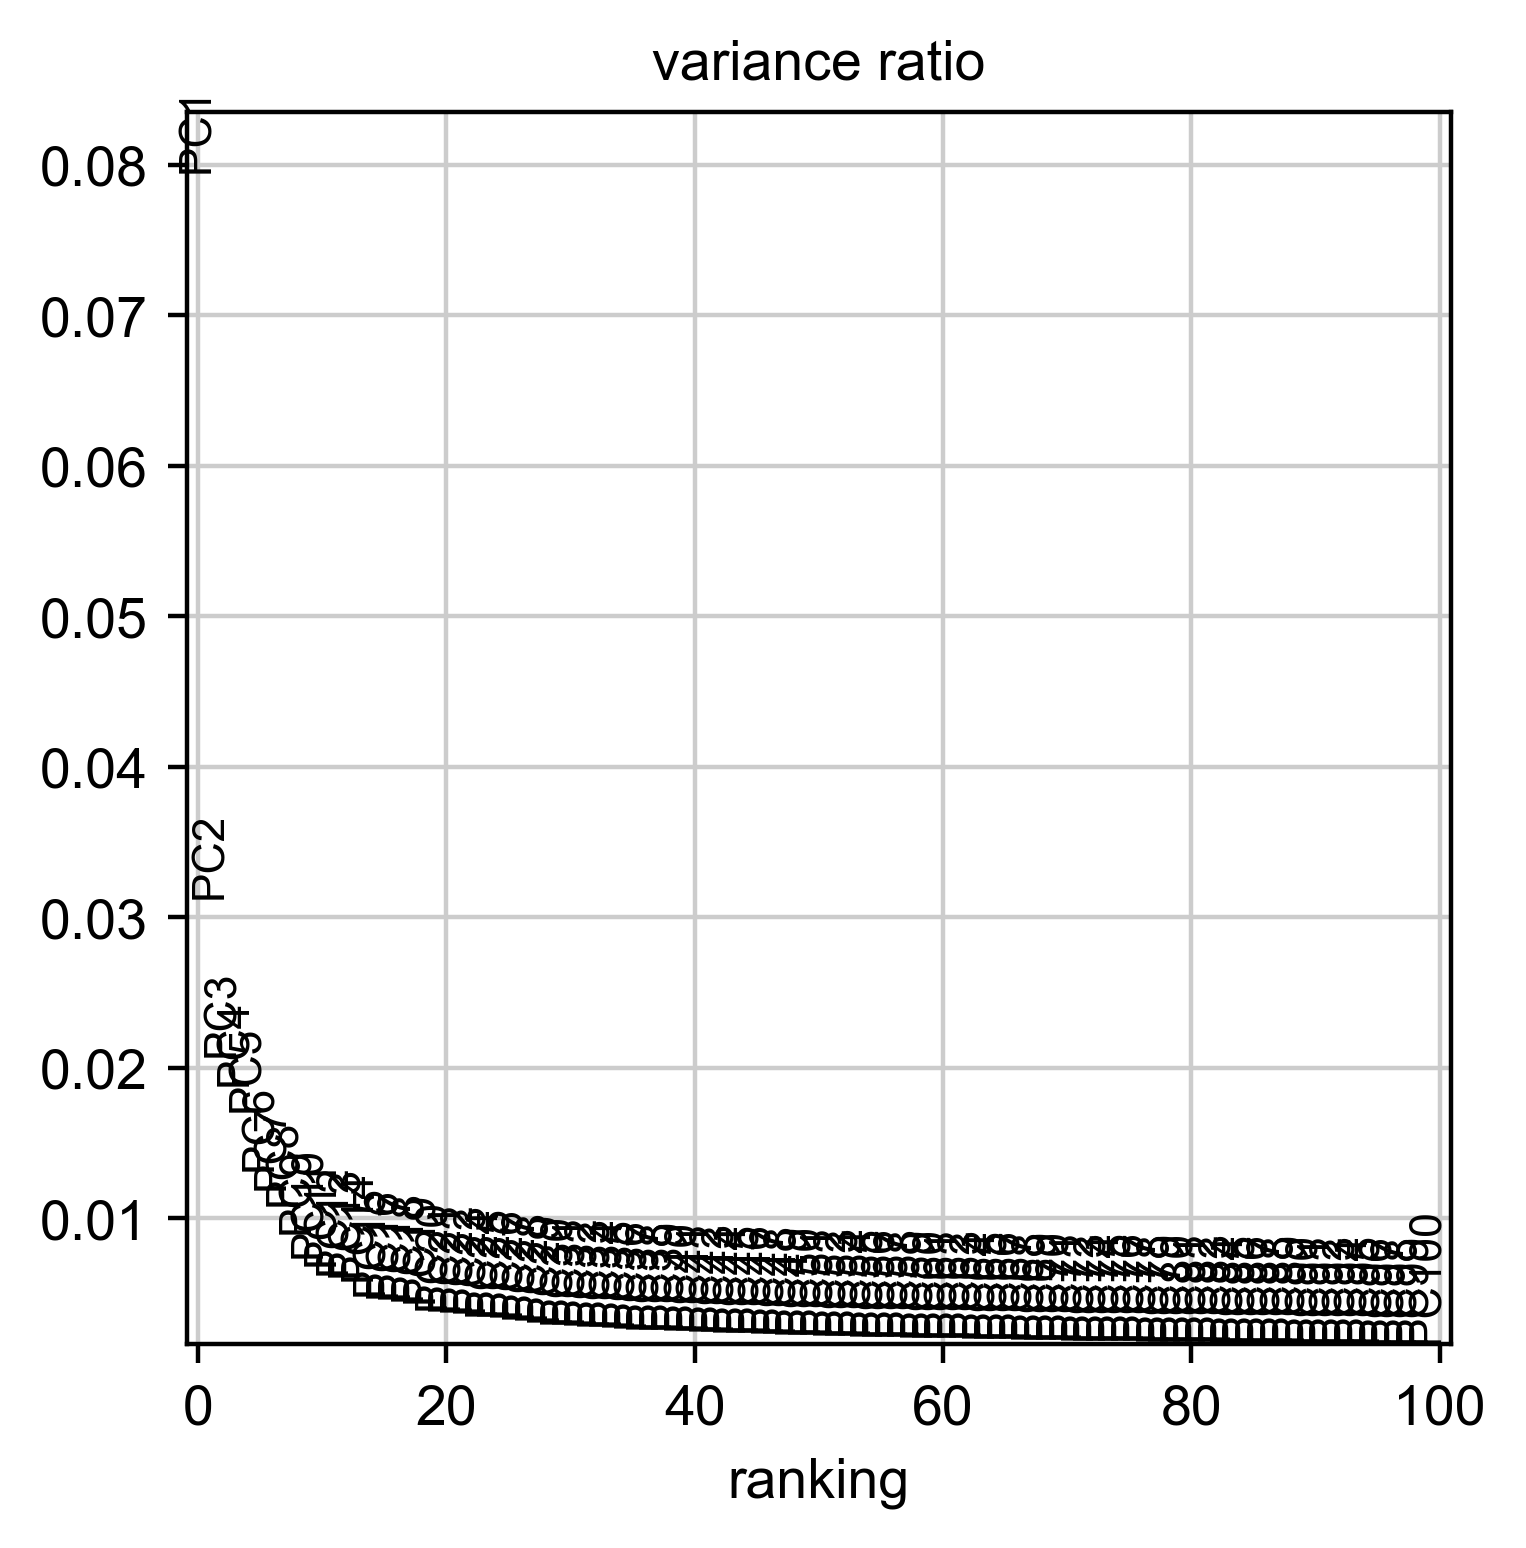

In [54]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100)

In [55]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [56]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [57]:
sc.tl.leiden(adata, resolution=0.15)

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [58]:
adata.obs

n_genes  n_genes_by_counts  total_counts  \
AAACCCAAGGATTTGA-1     3591               3586       14310.0   
AAACCCAGTCGGCACT-1     4929               4923       21178.0   
AAACCCAGTGAAGCTG-1     1012               1011        2148.0   
AAACGAAAGGCCTAAG-1      544                541         822.0   
AAACGAAAGGCGTTAG-1     3239               3236       10849.0   
...                     ...                ...           ...   
TTTCCTCTCGCTGACG-1     3752               3749       12583.0   
TTTGACTGTACAGTCT-1     1422               1421       10015.0   
TTTGACTTCGCCTTGT-1     4300               4287       16764.0   
TTTGGAGTCGTGTTCC-1     2051               2046        5449.0   
TTTGTTGGTTCCAGGC-1     4864               4859       23562.0   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACCCAAGGATTTGA-1                   27.484277                    40.118798   
AAACCCAGTCGGCACT-1                   21.673435                    31.962414   
AAACCCAGTGAAGCTG-1                   30.446927                    43.668529   
AAACGAAAGGCCTAAG-1                   28.710462                    42.457421   
AAACGAAAGGCGTTAG-1                   27.007097                    39.459858   
...                                        ...                          ...   
TTTCCTCTCGCTGACG-1                   24.652309                    33.203529   
TTTGACTGTACAGTCT-1                   44.682976                    64.603095   
TTTGACTTCGCCTTGT-1                   19.631353                    29.092102   
TTTGGAGTCGTGTTCC-1                   27.381171                    37.915214   
TTTGTTGGTTCCAGGC-1                   23.941092                    35.404465   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACCCAAGGATTTGA-1                    51.984626                    65.709294   
AAACCCAGTCGGCACT-1                    42.558315                    56.289546   
AAACCCAGTGAAGCTG-1                    57.635009                    76.210428   
AAACGAAAGGCCTAAG-1                    58.515815                    95.012165   
AAACGAAAGGCGTTAG-1                    50.493133                    64.125726   
...                                         ...                          ...   
TTTCCTCTCGCTGACG-1                    43.741556                    58.443932   
TTTGACTGTACAGTCT-1                    77.723415                    89.116326   
TTTGACTTCGCCTTGT-1                    40.288714                    55.774278   
TTTGGAGTCGTGTTCC-1                    50.027528                    66.893008   
TTTGTTGGTTCCAGGC-1                    46.311858                    59.786945   

                    total_counts_mt  pct_counts_mt leiden  
AAACCCAAGGATTTGA-1            400.0       2.795248      0  
AAACCCAGTCGGCACT-1            609.0       2.875626      0  
AAACCCAGTGAAGCTG-1              1.0       0.046555      1  
AAACGAAAGGCCTAAG-1             21.0       2.554744      1  
AAACGAAAGGCGTTAG-1            251.0       2.313577      0  
...                             ...            ...    ...  
TTTCCTCTCGCTGACG-1           1109.0       8.813478      0  
TTTGACTGTACAGTCT-1            647.0       6.460310      1  
TTTGACTTCGCCTTGT-1            754.0       4.497733      0  
TTTGGAGTCGTGTTCC-1            302.0       5.542301      0  
TTTGTTGGTTCCAGGC-1            899.0       3.815465      0  

[2260 rows x 10 columns]

In [ ]:
sc.pl.umap(adata, color=["leiden","Ptprc","Col6a3","Epcam", "Pecam1","Col1a1"],ncols=4)

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


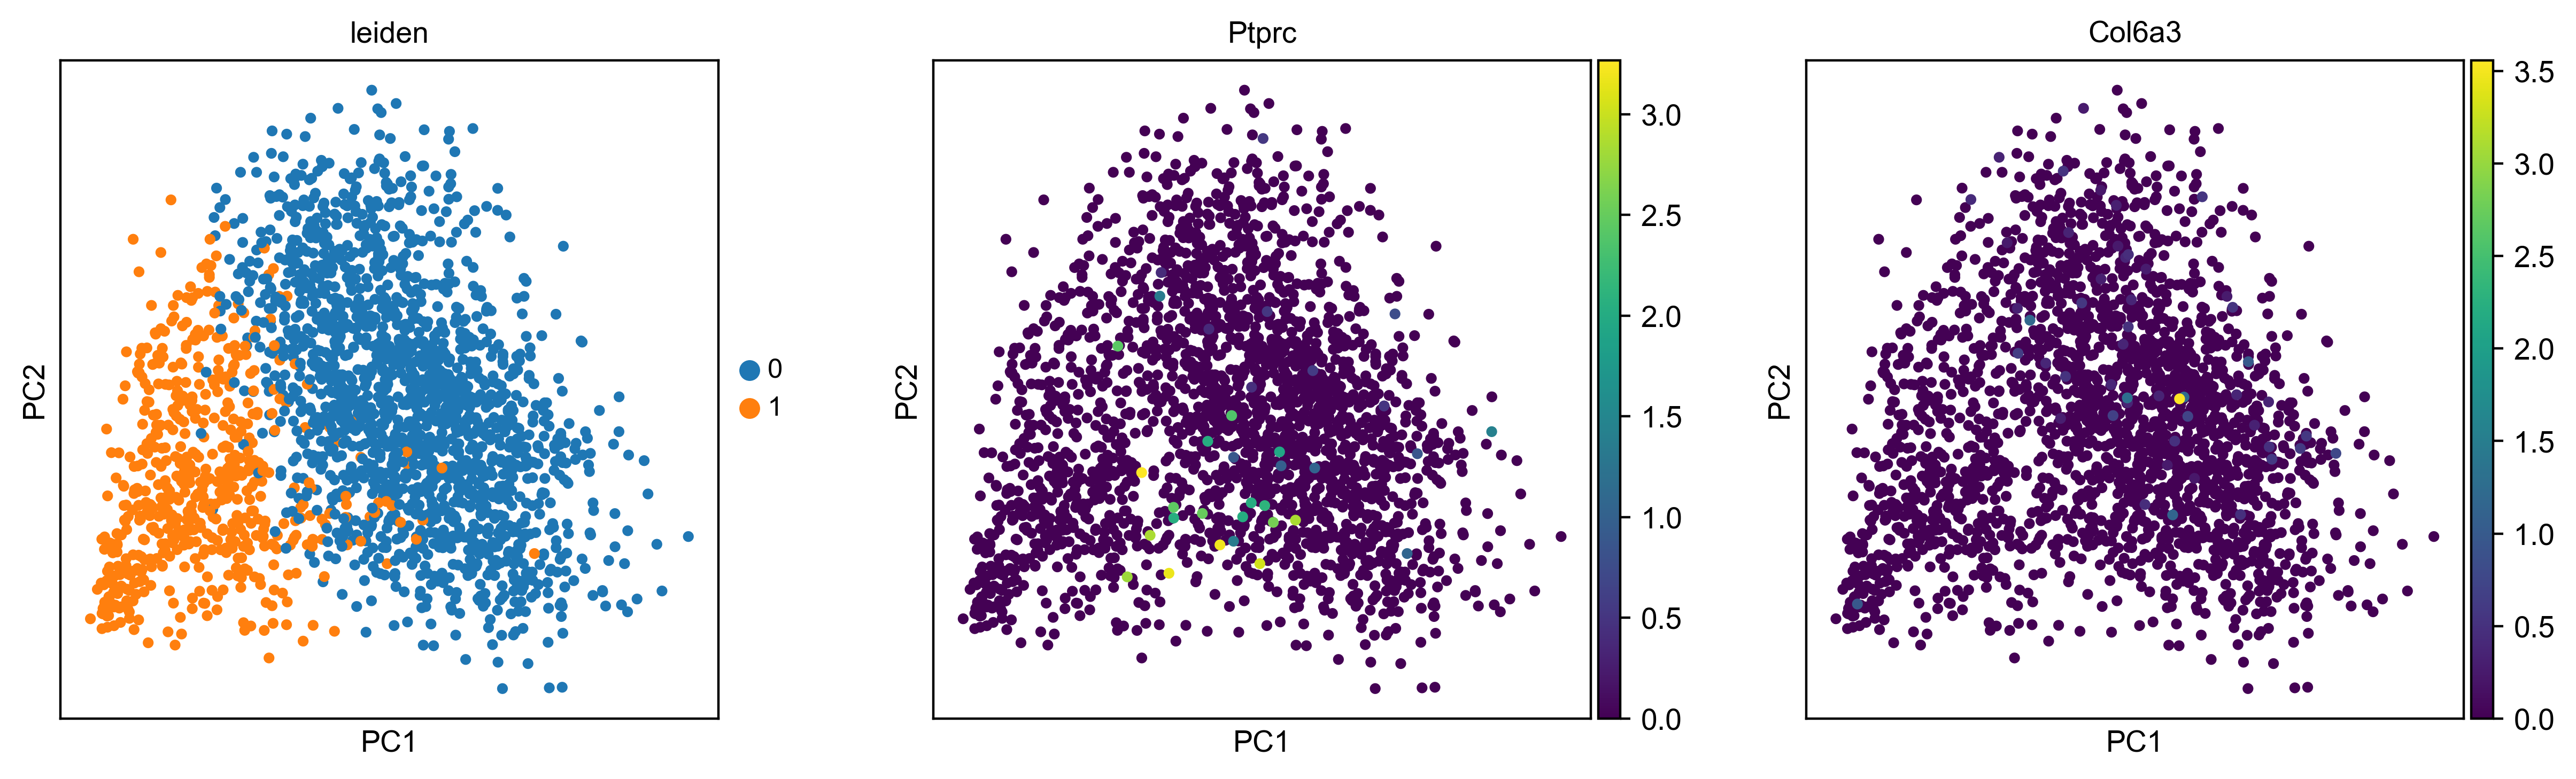

In [63]:
sc.pl.pca(adata, color=["leiden","Ptprc","Col6a3"],ncols=4)

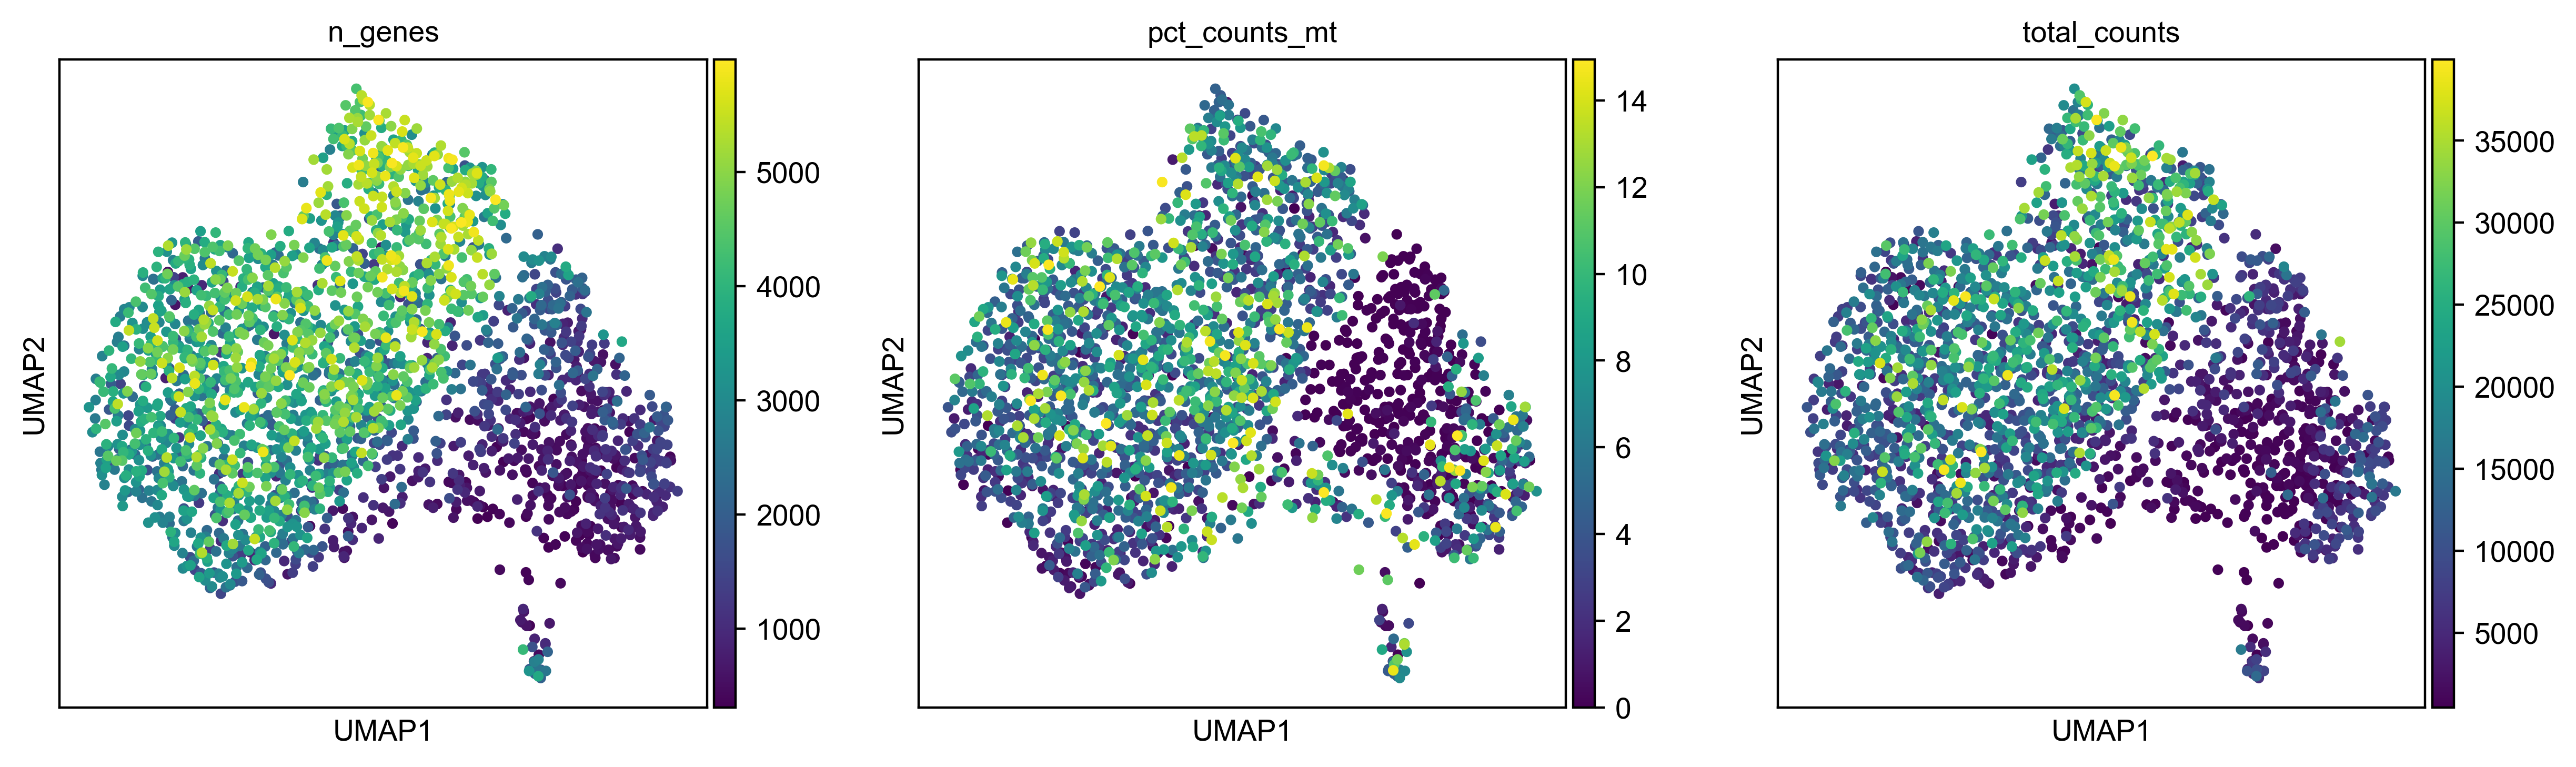

In [64]:
sc.pl.umap(adata, color=["n_genes","pct_counts_mt","total_counts"])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


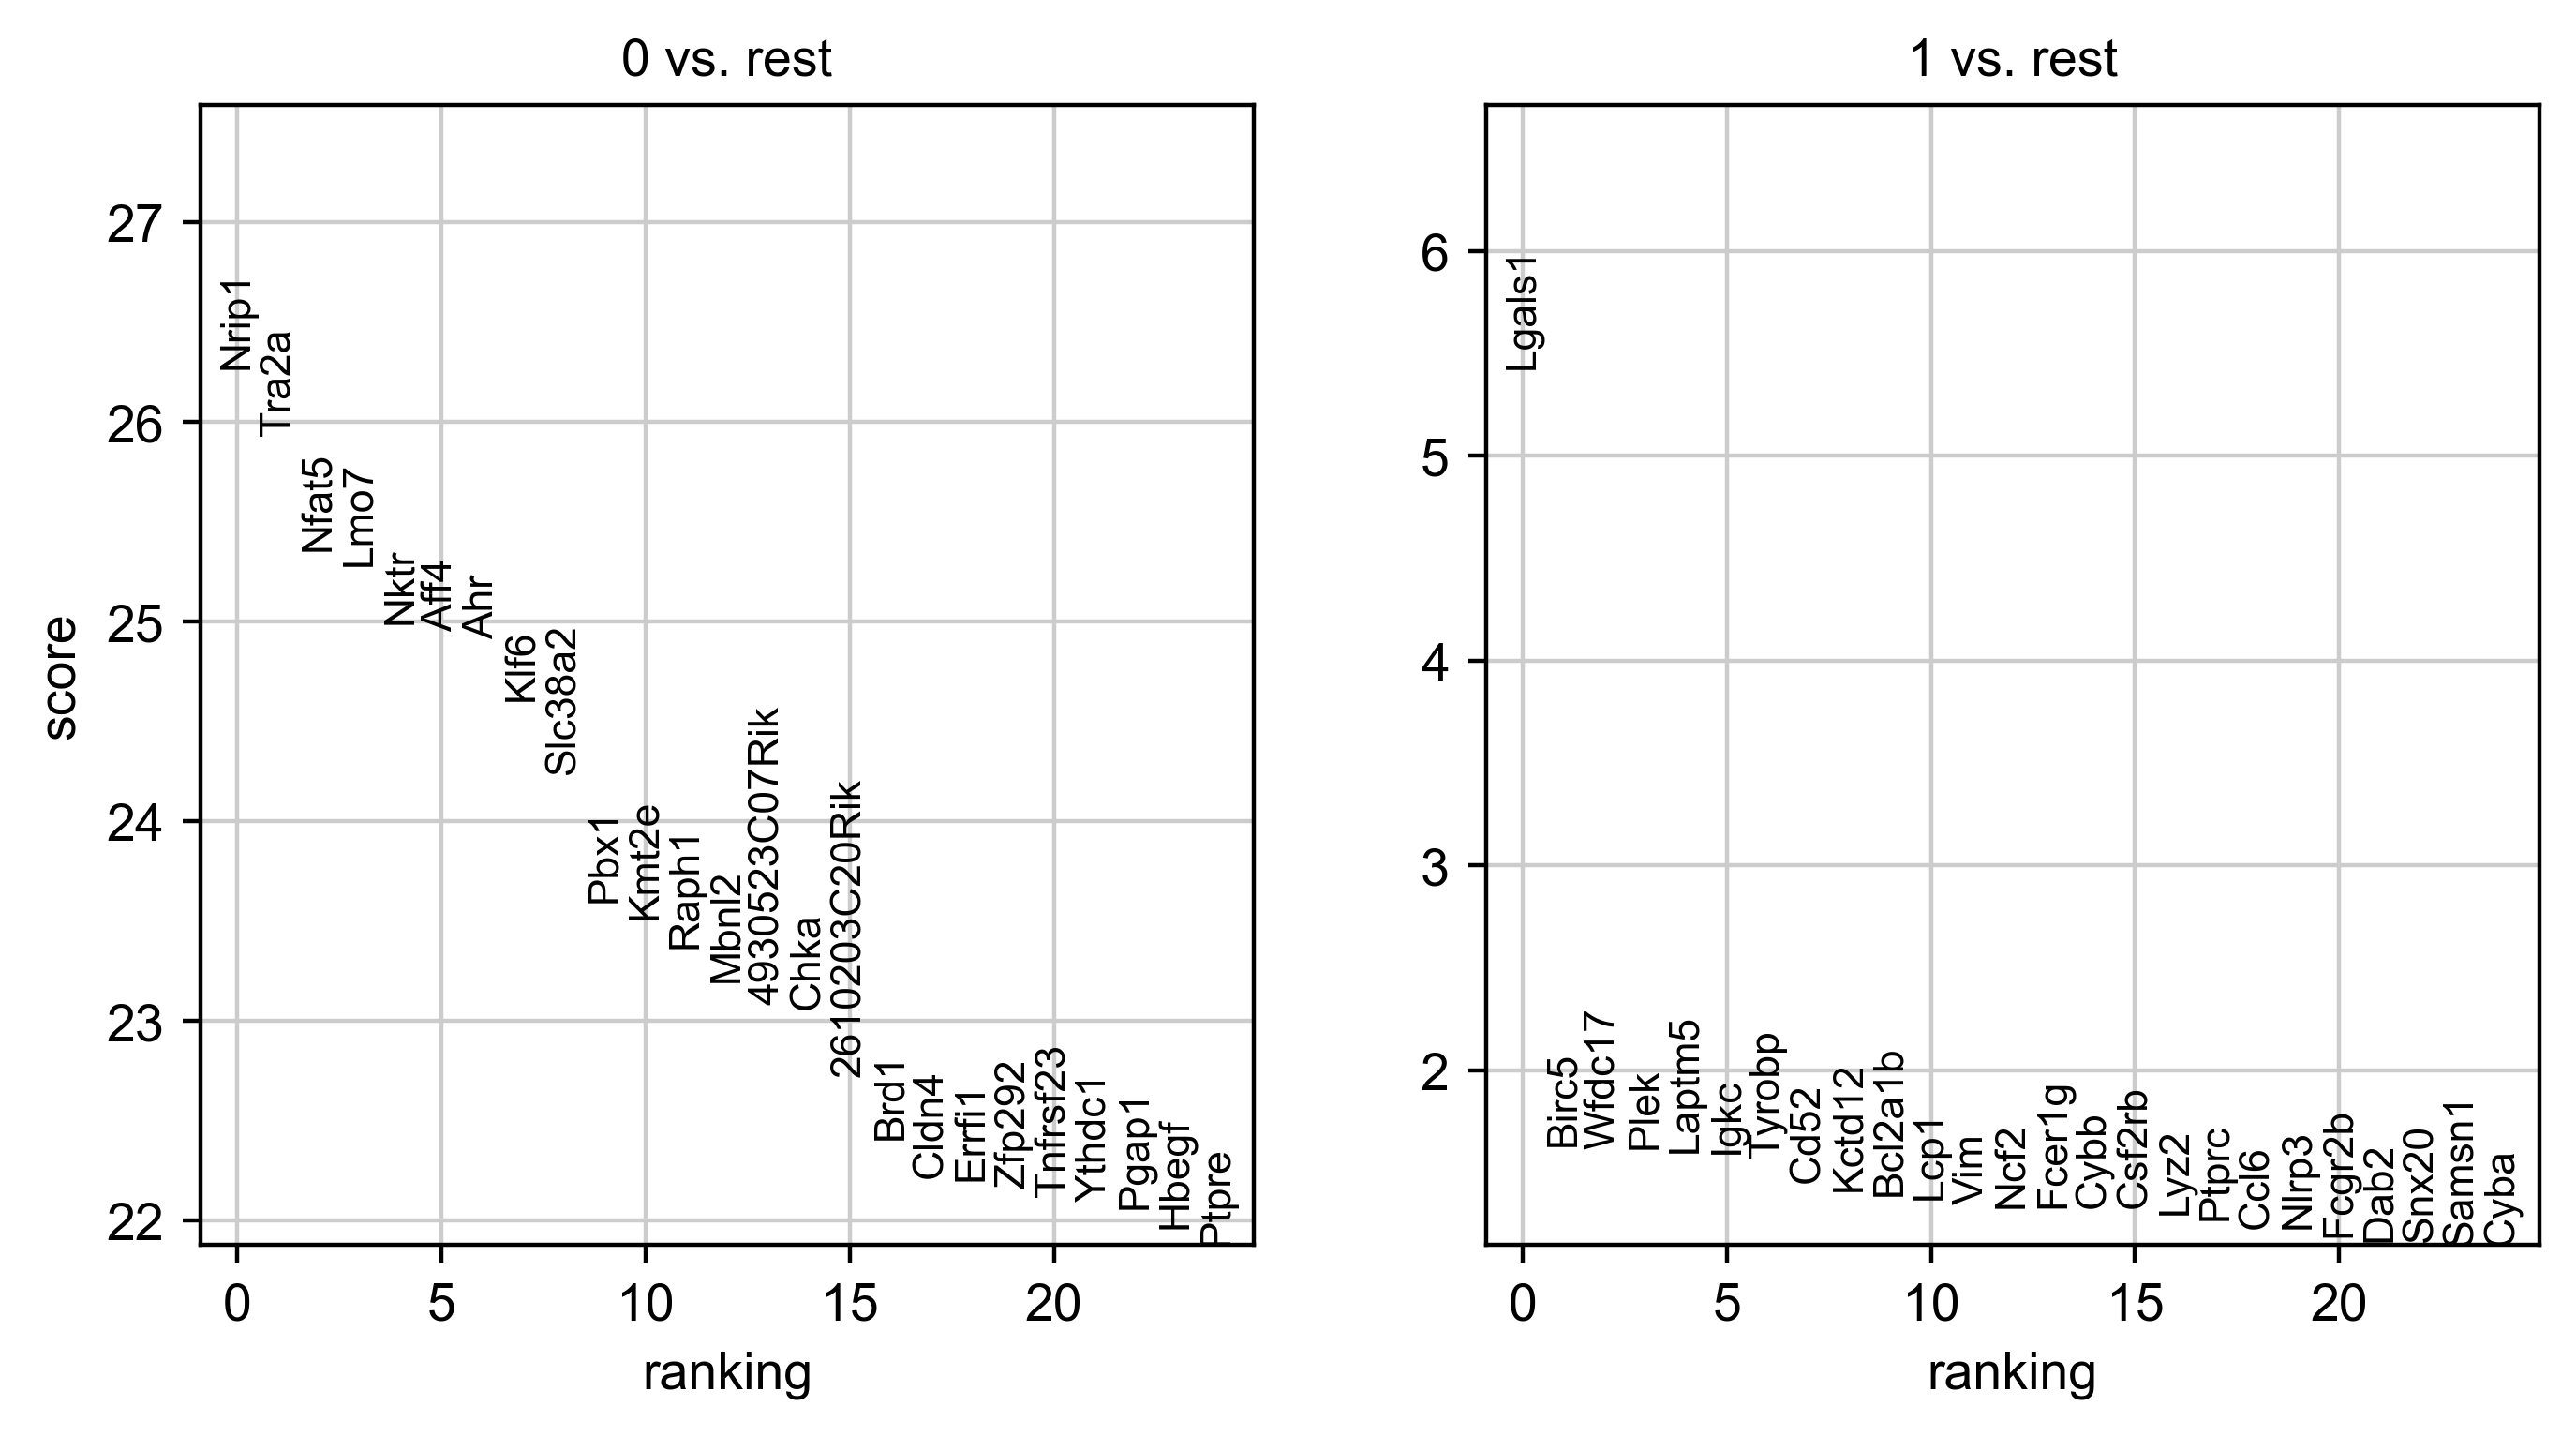

In [70]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', use_raw=False)
#sc.tl.filter_rank_genes_groups(adata, groupby="leiden", use_raw=False,
#                                   key_added='rank_genes_groups_filtered', 
#                                   min_in_group_fraction=0.25, min_fold_change=1, max_out_group_fraction=0.5, compare_abs=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [71]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(15)

0        1
0           Nrip1   Lgals1
1           Tra2a    Birc5
2           Nfat5   Wfdc17
3            Lmo7     Plek
4            Nktr   Laptm5
5            Aff4     Igkc
6             Ahr   Tyrobp
7            Klf6     Cd52
8         Slc38a2   Kctd12
9            Pbx1  Bcl2a1b
10          Kmt2e     Lcp1
11          Raph1      Vim
12          Mbnl2     Ncf2
13  4930523C07Rik   Fcer1g
14           Chka     Cybb

    using 'X_pca' with n_pcs = 40
Storing dendrogram info using `.uns['dendrogram_leiden']`


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What

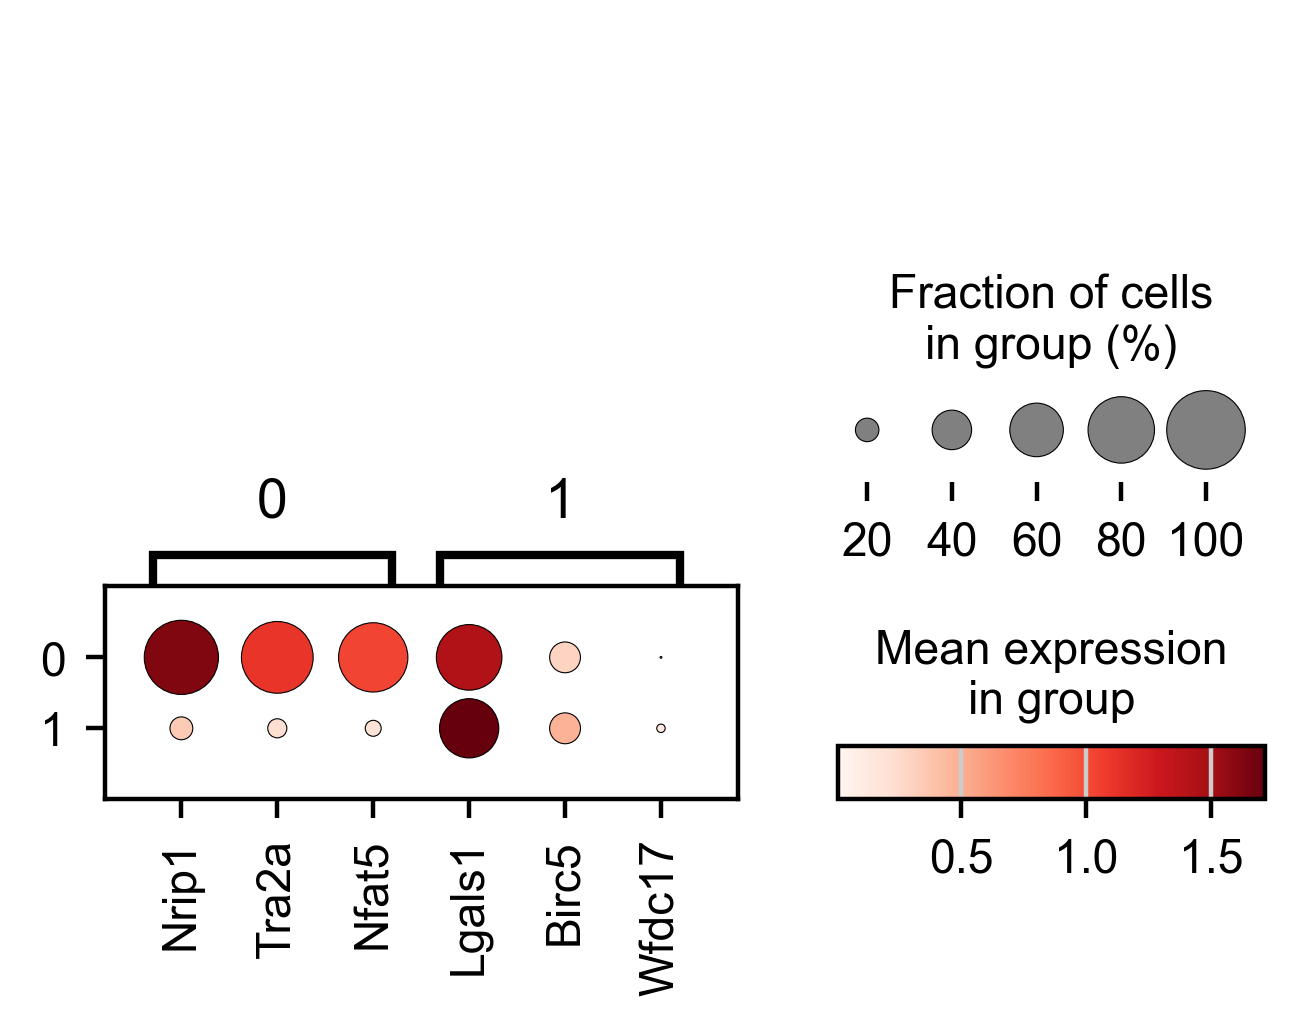

In [72]:
sc.tl.dendrogram(adata,groupby="leiden", n_pcs=40)
sc.pl.rank_genes_groups_dotplot(adata,n_genes=3)#,key="rank_genes_groups_filtered")

In [80]:
sigFile = "../mhCompTiss/data/LUAD/simpLUADbig.csv"
sigGenes = pd.read_csv(sigFile).dropna()
hpcs = sigGenes["hpcs"]

In [66]:
sc.tl.score_genes(adata, hpcs, score_name="HPCS_score")

computing score 'HPCS_score'
    finished: added
    'HPCS_score', score of gene set (adata.obs).
    1084 total control genes are used. (0:00:00)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


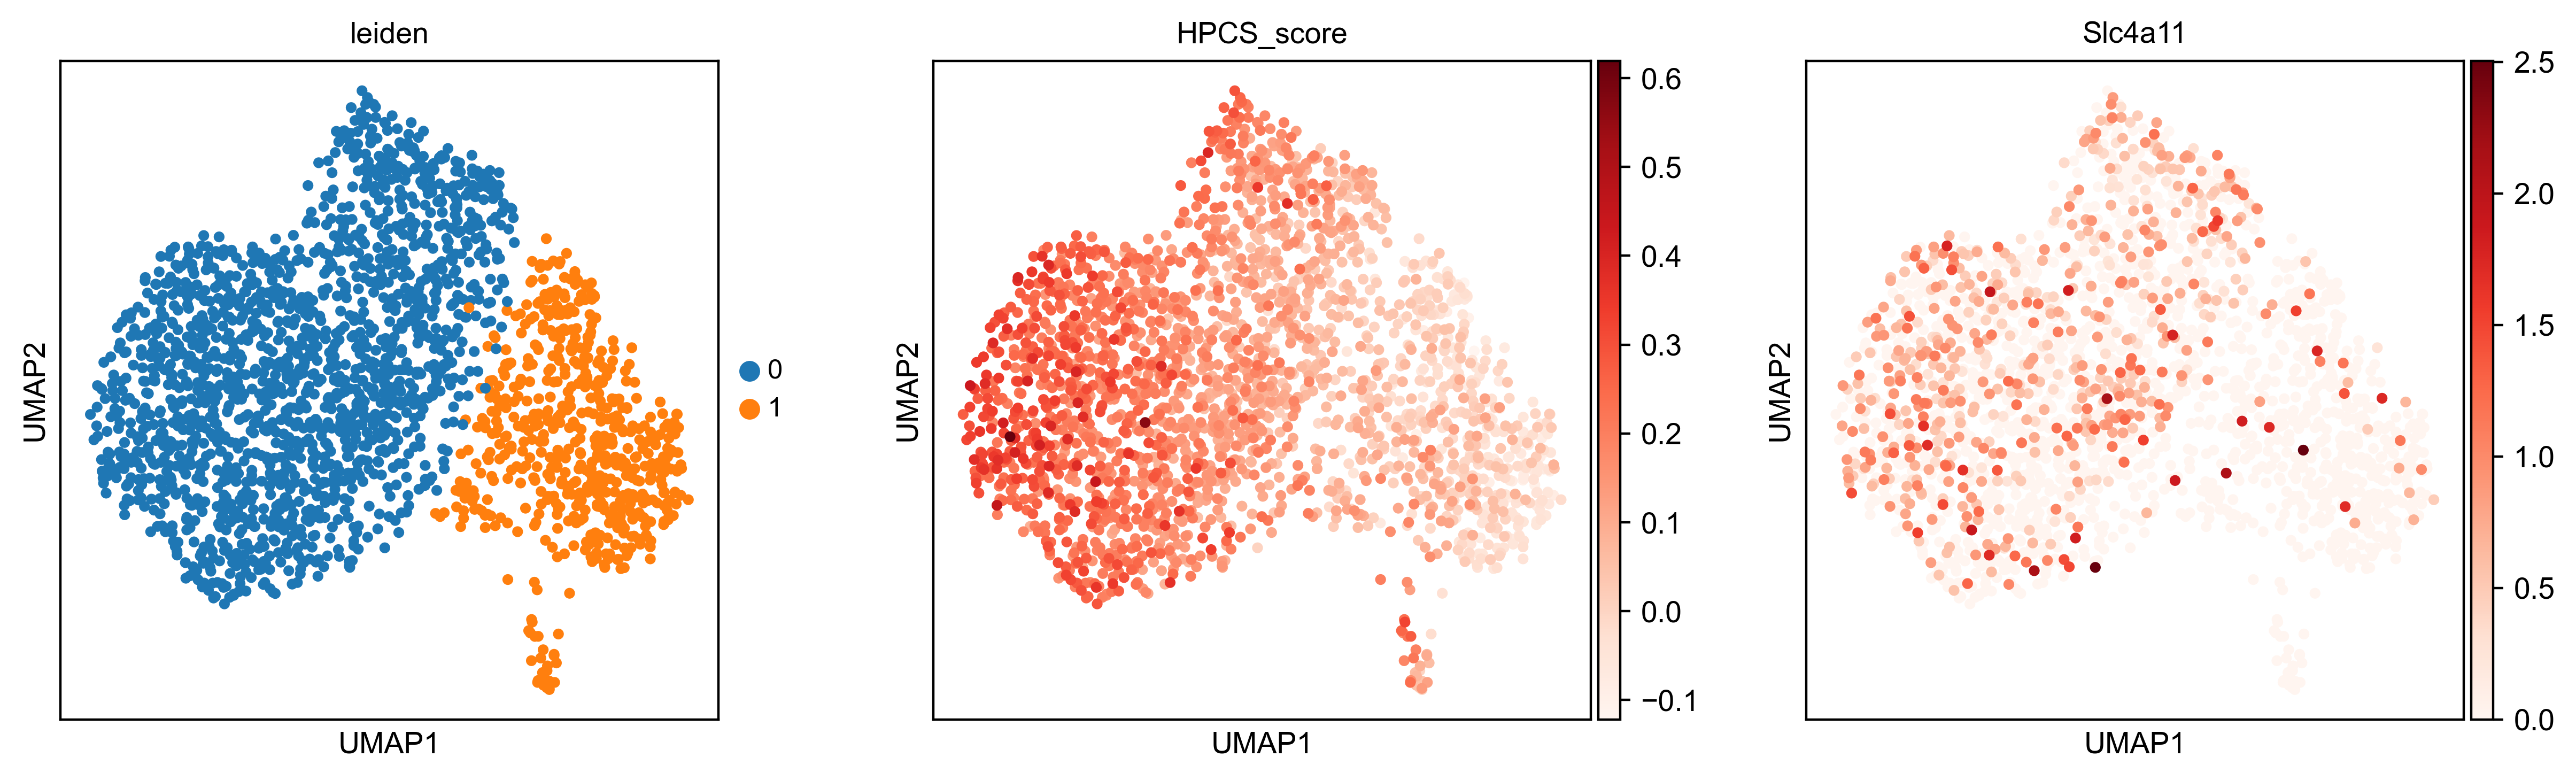

In [68]:
sc.pl.umap(adata, color=["leiden","HPCS_score","Slc4a11"],ncols=3, cmap="Reds")

In [83]:
for g in sigGenes["adv"]:
    if g in ["Plaur", "Procr", "F2r", "Slc4a11", "Itga2", "Cldn4"]:
        print(g)

In [82]:
sigGenes["adv"]

at2      at1           hpcs     endo      adv
0      Ifi27l2a     Map6        Slc4a11    Neil3    Stmn2
1       Gm13449  Gm43431          Il23a     Prtg    Klhl1
2         Tgtp1  Gm29237           Rrad    Upk1b    Rgs17
3    AC133650.1    Akap5            Tnf     Knl1   Ifi211
4          Ly6i      Hck          Abtb2   Cyp1b1     Bmp7
..          ...      ...            ...      ...      ...
200     Slc39a8    Vamp8         Osbpl3     Evpl   Sema6d
202       Megf9    Anxa5         Smim15  Zfp385b  Pstpip1
204        Bst2   Col4a2  4931406P16Rik   Kif20a    Tgfb1
206     Slc26a4    Ccnd3          Spag9     Gzme     Add2
208         B2m   Osbpl5         Ints12     Maob  Gm44126

[187 rows x 5 columns]

In [73]:
resultsFile

'write/mouseColon11302.h5ad'

In [74]:
adata.write(resultsFile)
adata

AnnData object with n_obs × n_vars = 2260 × 2062
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'HPCS_score'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'